In [1]:
import time
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping

import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

# prevent tensorflow from allocating the entire GPU memory at once
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


tensorflow ver.: 1.0.0
keras ver.: 2.0.3


## Functions
### Functions for loading data

In [2]:
def prep_data():
    data = pd.read_csv('../data/4A_201701_201705.csv', sep=';')

    data = data[(data['LineDirectionCode'] == 1)]
    data = data[(1 <= data['LineDirectionLinkOrder']) & (data['LineDirectionLinkOrder'] <= 31)]
    assert len(data['LinkRef'].unique()) == 30

    data.sort_values('DateTime', inplace = True)

    # Add a reference date for grouping similar measurements
    ix = pd.DatetimeIndex(pd.to_datetime(data['DateTime'])).floor('15min')
    df = pd.DataFrame(data = {
            'year': 2000,
            'month': 1,
            'day': data['DayOfWeek'],
            'hour': ix.hour,
            'minute': ix.minute
    })
    data['DateTimeReference'] = pd.to_datetime(df)
    return data

In [3]:
def fit_scale(data, freq = '15min', smooth = 7):
    means = { }
    scales = { }
    low = { }
    upr = { }
    for k, v in data.sort_values('LineDirectionLinkOrder').groupby('LinkRef', sort = False):
        v_nonan = v[~np.isnan(v['LinkTravelTime'])]

        median = np.median(v_nonan['LinkTravelTime']);
        mad = 1.4826 * np.median(np.abs(v_nonan['LinkTravelTime'] - median))
        low[k] = max(median - 3 * mad, 0) # v['LinkTravelTime'].quantile(0.1)
        upr[k] = median + 3 * mad # v['LinkTravelTime'].quantile(0.9)

        ix_ref = pd.DatetimeIndex(pd.to_datetime(v['DateTimeReference']))
        v_ = v.set_index(ix_ref)

        mean = v_[(low[k] < v_['LinkTravelTime']) & (v_['LinkTravelTime'] < upr[k])]['LinkTravelTime'].resample(freq).mean()
        mean = mean.interpolate().rolling(window = smooth, center = True).mean()
        means[k] = mean 
        #scales[k] = v_[(low[k] < v_['LinkTravelTime']) & (v_['LinkTravelTime'] < upr[k])]['LinkTravelTime'].std()
        scales[k] = 1

    means_df = pd.DataFrame(data = means).fillna(method='pad').fillna(method='bfill')
    return (means_df, scales, low, upr)

In [4]:
def transform(data, means_df, scales, low, upr, freq = '15min'):
    tss = { }
    ws = { }
    removed_mean = { }
    removed_scale = { }
    ks = []
    for k, v in data.sort_values('LineDirectionLinkOrder').groupby('LinkRef', sort = False):
        # Link Data Time Indexed
        link_time_ix = pd.DatetimeIndex(pd.to_datetime(v['DateTime']))    
        link_time_ixd = v.set_index(link_time_ix)
        
        # Remove outliers
        link_time_ixd = link_time_ixd[(low[k] < link_time_ixd['LinkTravelTime']) & (link_time_ixd['LinkTravelTime'] < upr[k])]
        link_time_ix = link_time_ixd.index
        
        # Link Reference Data Index
        ix_ref = pd.DatetimeIndex(pd.to_datetime(link_time_ixd['DateTimeReference']))    

        link_travel_time_k = link_time_ixd['LinkTravelTime'].resample(freq).mean()
        removed_mean[k] = pd.Series(data = means_df.loc[ix_ref, k].values, index = link_time_ix).resample(freq).mean()
        removed_scale[k] = pd.Series(data = np.repeat(scales[k], link_travel_time_k.shape[0]), index = link_travel_time_k.index)
        tss[k] = (link_travel_time_k - removed_mean[k].values) / removed_scale[k].values
        ws[k] = link_time_ixd['LinkTravelTime'].resample(freq).count()

        ks.append(k)
        
    ts = pd.DataFrame(data = tss).fillna(method='pad').fillna(0) # Link Travel Time Time Series
    df_removed_mean = pd.DataFrame(data = removed_mean, index = ts.index).fillna(method='pad').fillna(method='bfill') # Removed Mean from Link Travel Time
    df_removed_scale = pd.DataFrame(data = removed_scale, index = ts.index).fillna(method='pad').fillna(method='bfill')
    w = pd.DataFrame(data = ws).fillna(0) # Link Travel Time Weights, e.g. number of measurements
    return (ts.index, ts.values, df_removed_mean.values, df_removed_scale.values, w.values, ks)

### Functions for generate data

In [5]:
def build_model(input_timesteps, output_timesteps):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, 30, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (5, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.2, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.1, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, 30, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.1, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(Dense(units=1, name = 'dense_2'))

    optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
    model.compile(loss = "mse", optimizer = optimizer)
    return model

## Load data

In [6]:
data = prep_data()
data.shape

(814710, 11)

### Mean center

In [7]:
(means, scales, low, upr) = fit_scale(data, smooth = 7)
assert means.shape[0] == 4 * 24 * 7
assert len(scales) == 30
assert len(low) == 30
assert len(upr) == 30
(means.shape, len(scales), len(low), len(upr))

((672, 30), 30, 30, 30)

In [8]:
ix, ts, removed_mean, removed_scale, w, ks = transform(data, means, scales, low, upr)
(ix.shape, ts.shape, removed_mean.shape, removed_scale.shape, w.shape)

((14494,), (14494, 30), (14494, 30), (14494, 30), (14494, 30))

## Look at data

### Look at means (reference data)

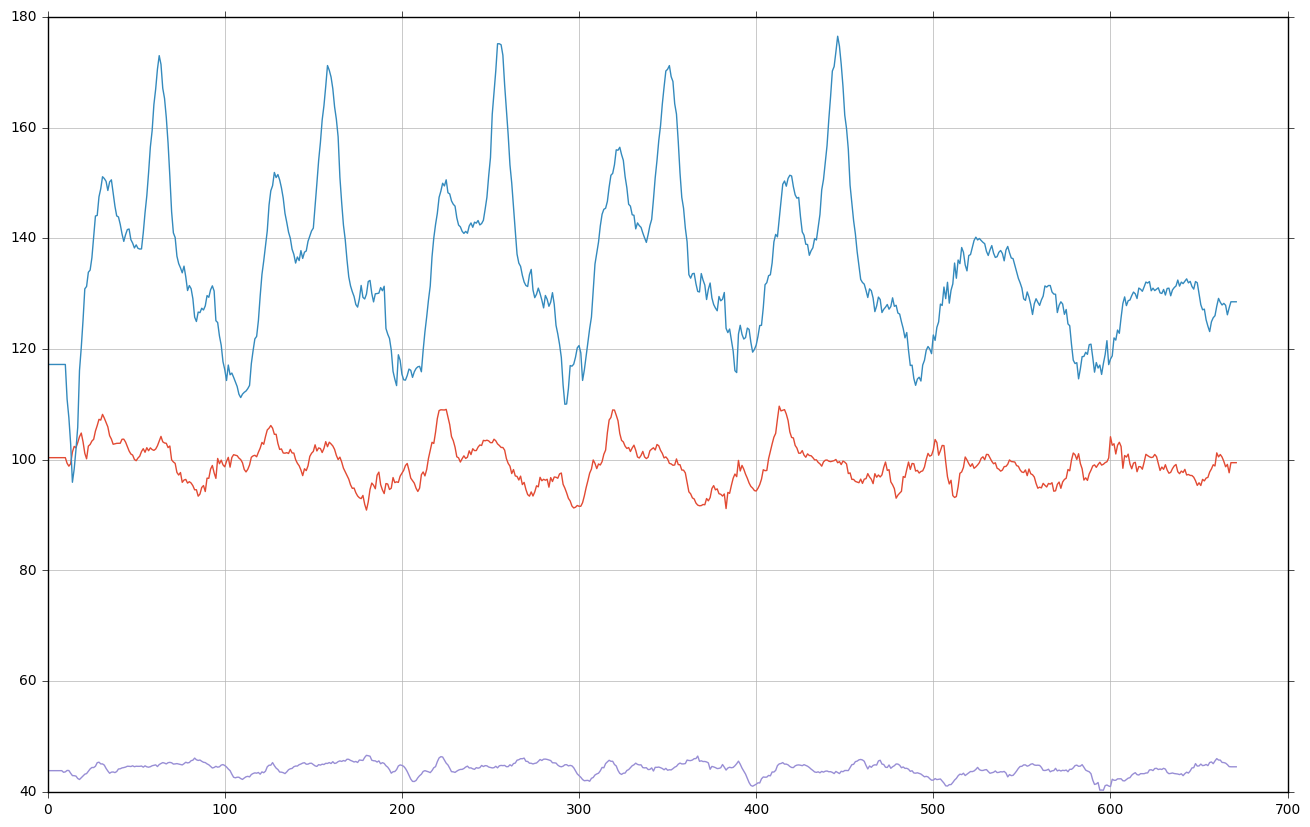

In [9]:
plt.plot(means.iloc[:,6:9].values)
#plt.legend(means_df.columns, loc='upper right')
plt.show()

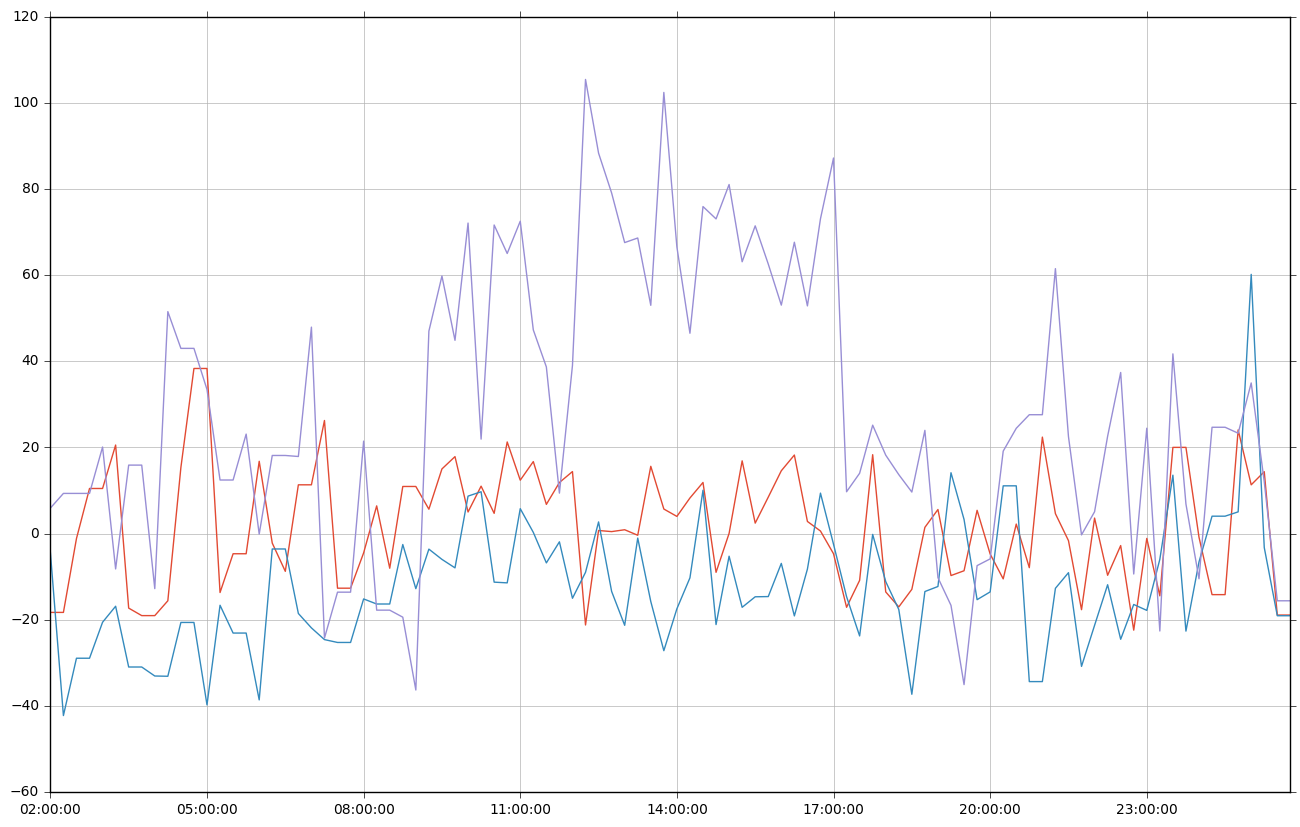

In [10]:
plt.plot(ix[6*4*24:7*4*24], ts[6*4*24:7*4*24,5:8])
plt.show()

In [11]:
lags = 4 * 8
preds = 5
build_model(lags, preds).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 32, 30, 1, 1)      4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 32, 30, 1, 64)     166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 30, 1, 64)     0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 32, 30, 1, 64)     256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 30, 1, 64)         164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 1, 64)         0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 30, 1, 64)         256       
__________

## Train and test

In [12]:
X = np.stack([np.roll(ts, i, axis = 0) for i in range(lags, 0, -1)], axis = 1)[lags:-preds,:,:,np.newaxis,np.newaxis]
y = np.stack([np.roll(ts, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:,np.newaxis,np.newaxis]
ix_y = ix[lags:-preds]
y_mean = np.stack([np.roll(removed_mean, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:]
y_scale = np.stack([np.roll(removed_scale, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:]
w_y = np.stack([np.roll(w, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:]

(X.shape, y.shape, ix_y.shape, y_mean.shape, y_scale.shape, w_y.shape)

((14459, 32, 30, 1, 1),
 (14459, 3, 30, 1, 1),
 (14459,),
 (14459, 3, 30),
 (14459, 3, 30),
 (14459, 3, 30))

In [13]:
global_start_time = time.time()
csv_logger = CSVLogger('logs/ConvLSTM_5x15min_5x64-5x64-5x64-5x64.log')
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

bootstrap_size = int(len(y)*0.75)
n_test = int(len(y)*0.05)
n_windows = 5

hist = []
windows = []
for i in range(bootstrap_size, min(bootstrap_size + n_windows * n_test, len(y)), n_test):
    windows.append((i, i + n_test))
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Current window: " + str(i) + " - " + str(i+n_test))
    
    X_train = X[:i,]
    y_train = y[:i,]
    
    X_test = X[i:i+n_test,]
    y_test = y[i:i+n_test,]    
    w_test = w_y[i:i+n_test,]
    
    model = build_model(lags, preds)
    
    # Train
    history = model.fit(X_train, y_train,
                        batch_size = 512, epochs = 30,
                        shuffle = False, validation_data = (X_test, y_test),
                        verbose = 0, callbacks = [csv_logger, early_stopping])
    hist.append(history)
    model.save('models/ConvLSTM_5x15min_5x64-5x64-5x64-5x64_' + str(i) + '.h5') 
    
    y_true = y_test.squeeze() * y_scale[i:i+n_test,] + y_mean[i:i+n_test,]
    y_naive = y_mean[i:i+n_test,]
    y_pred = model.predict(X_test).squeeze() * y_scale[i:i+n_test,] + y_mean[i:i+n_test,]
        
    y_true_total = np.sum(y_true * w_test, axis = 2).squeeze()
    y_naive_total = np.sum(y_naive * w_test, axis = 2).squeeze()
    y_pred_total = np.sum(y_pred * w_test, axis = 2).squeeze()

    for t in range(preds):
        mask = y_true_total[:,t] > 0
        y_true_total_t = y_true_total[mask, t] / 60
        y_naive_total_t = y_naive_total[mask, t] / 60
        y_pred_total_t = y_pred_total[mask, t] / 60  

        error_naive_total_t = (y_naive_total_t - y_true_total_t)
        error_lstm_total_t = (y_pred_total_t - y_true_total_t)

        mae_ha = np.mean(np.abs(error_naive_total_t))
        rmse_ha = np.sqrt(np.mean((error_naive_total_t)**2))
        mape_ha = np.mean(np.abs(error_naive_total_t) / y_true_total_t) * 100

        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " - t + %d - HA   - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_ha, rmse_ha, mape_ha))

        mae_lstm = np.mean(np.abs(error_lstm_total_t))
        rmse_lstm = np.sqrt(np.mean((error_lstm_total_t)**2))
        mape_lstm = np.mean(np.abs(error_lstm_total_t) / y_true_total_t) * 100

        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " - t + %d - LSTM - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm, rmse_lstm, mape_lstm))
        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " - t + %d - *    - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm - mae_ha, rmse_lstm - rmse_ha, mape_lstm - mape_ha))

print('Training duration (s) : ', time.time() - global_start_time)    

2017-08-24 13:42:39 Current window: 10844 - 11566
2017-08-24 13:54:12 - t + 1 - HA   - MAE:  4.76 - RMSE:  6.24 - MAPE:  7.33
2017-08-24 13:54:12 - t + 1 - LSTM - MAE:  4.29 - RMSE:  5.70 - MAPE:  6.72
2017-08-24 13:54:12 - t + 1 - *    - MAE: -0.47 - RMSE: -0.54 - MAPE: -0.61
2017-08-24 13:54:12 - t + 2 - HA   - MAE:  4.76 - RMSE:  6.23 - MAPE:  7.33
2017-08-24 13:54:12 - t + 2 - LSTM - MAE:  4.33 - RMSE:  5.76 - MAPE:  6.78
2017-08-24 13:54:12 - t + 2 - *    - MAE: -0.42 - RMSE: -0.47 - MAPE: -0.55
2017-08-24 13:54:12 - t + 3 - HA   - MAE:  4.76 - RMSE:  6.23 - MAPE:  7.33
2017-08-24 13:54:12 - t + 3 - LSTM - MAE:  4.34 - RMSE:  5.77 - MAPE:  6.78
2017-08-24 13:54:12 - t + 3 - *    - MAE: -0.42 - RMSE: -0.47 - MAPE: -0.55
2017-08-24 13:54:12 Current window: 11566 - 12288
2017-08-24 14:07:25 - t + 1 - HA   - MAE:  4.48 - RMSE:  6.03 - MAPE:  6.56
2017-08-24 14:07:25 - t + 1 - LSTM - MAE:  2.85 - RMSE:  3.97 - MAPE:  4.69
2017-08-24 14:07:25 - t + 1 - *    - MAE: -1.63 - RMSE: -2.06 - 

In [ ]:
for history in hist:
    plt.plot(history.history['loss'])
for history in hist:
    plt.plot(history.history['val_loss'], linestyle = '--')
    
fig = plt.figure(figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.plot(np.array(hist[-2].history['loss']) / 60)
ax.plot(np.array(hist[-2].history['val_loss']) / 60, linestyle = '--')
plt.ylabel('loss (min)', fontsize = 14)
plt.xlabel('epoch', fontsize = 14)
plt.legend(['train', 'test'], loc='upper right')
#plt.show()
fig.savefig('conv_lstm_model_loss.pdf')
#fig.close()

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

In [ ]:
plt.plot(y_test[:200,0,:1,0].squeeze(), color = 'b', linestyle = '--')
plt.plot(y_pred[:200,0,:1,0].squeeze(), color = 'r', linestyle = '--')



#plt.plot(y_test[:20,10,0], color = 'r', linestyle = '-.')

plt.show()